In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58618 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:58621" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:58651, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:58645, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:58648, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

# RandomForest 10 Estimators

In [8]:
rf10 = RandomForestRegressor(n_estimators=10, verbose=True)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
with joblib.parallel_backend('dask'):
    rf10.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.2s finished


In [9]:
rf_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in rf10.get_params():
    rf_scores[param]=[]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


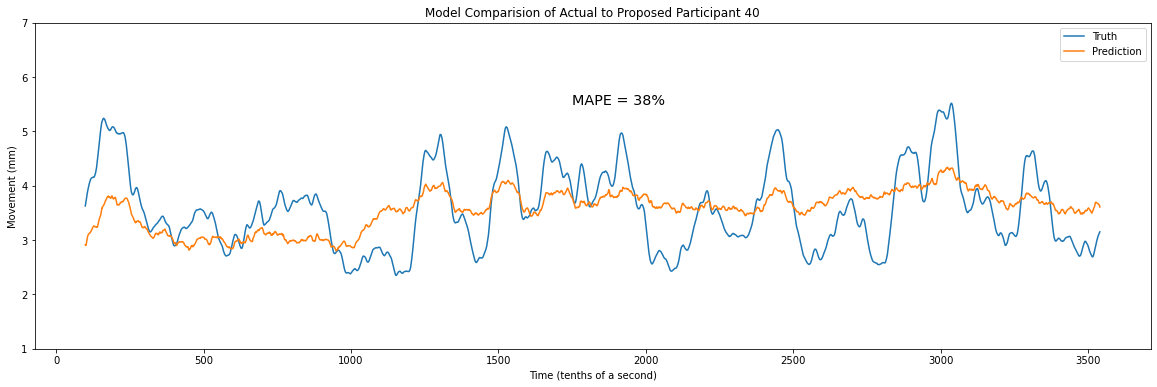

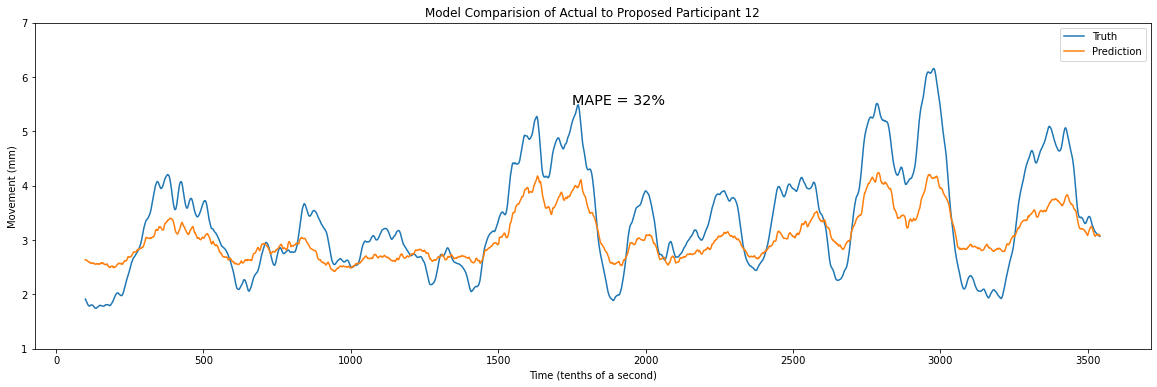

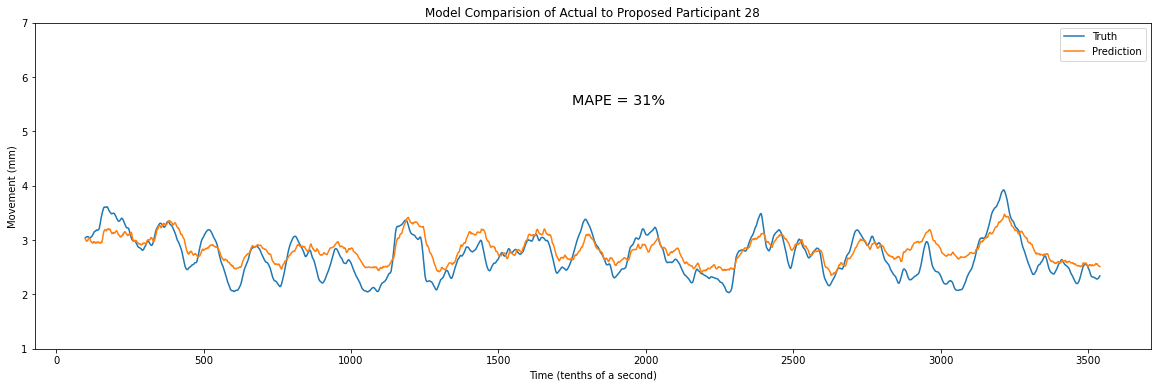

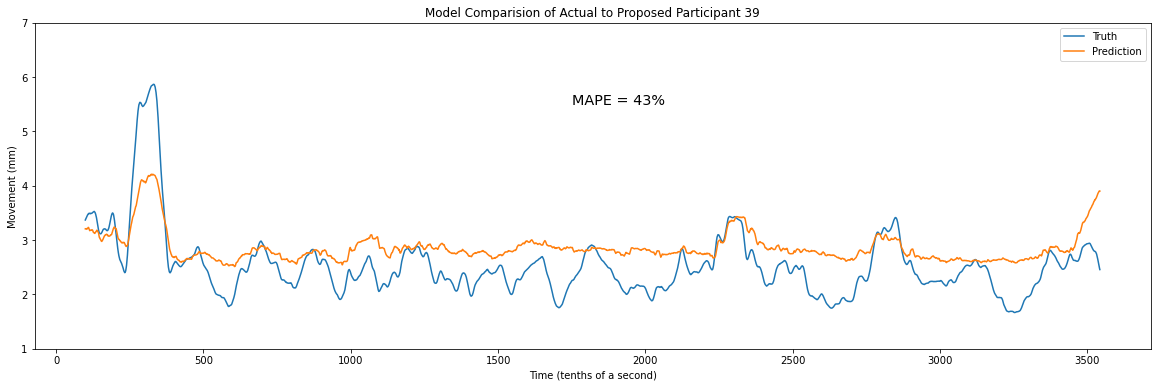

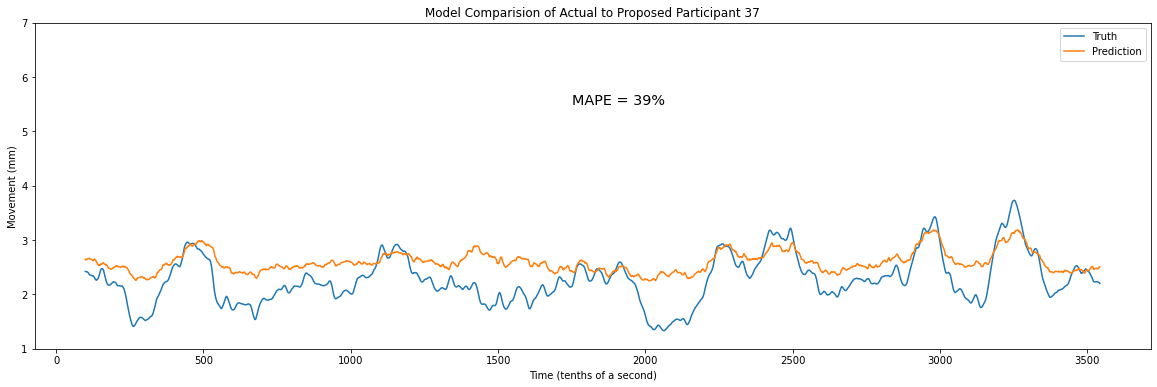

In [10]:
results, rf_scores = score_model(rf10, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='RF10', log = rf_scores)
plot_predictions(results, participants)

In [11]:
rf_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# RandomForest 50 Estimators

In [12]:
rf50 = RandomForestRegressor(n_estimators=50, verbose=True)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
with joblib.parallel_backend('dask'):
    rf50.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


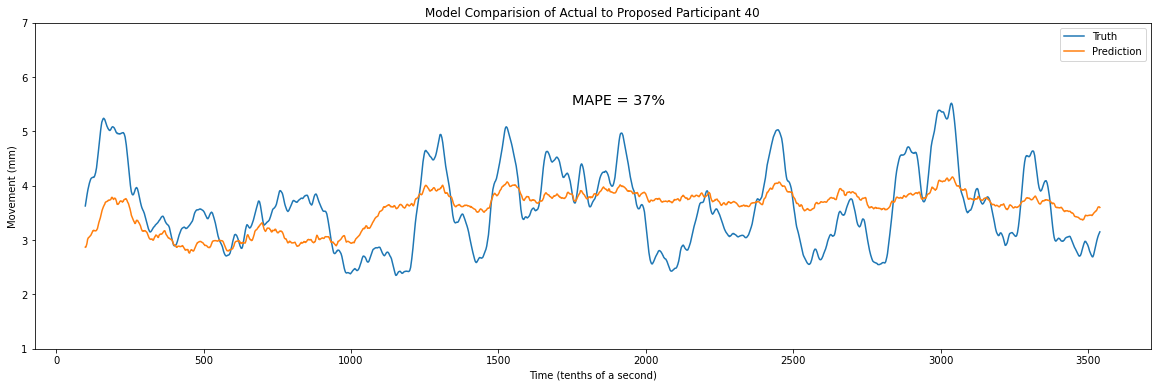

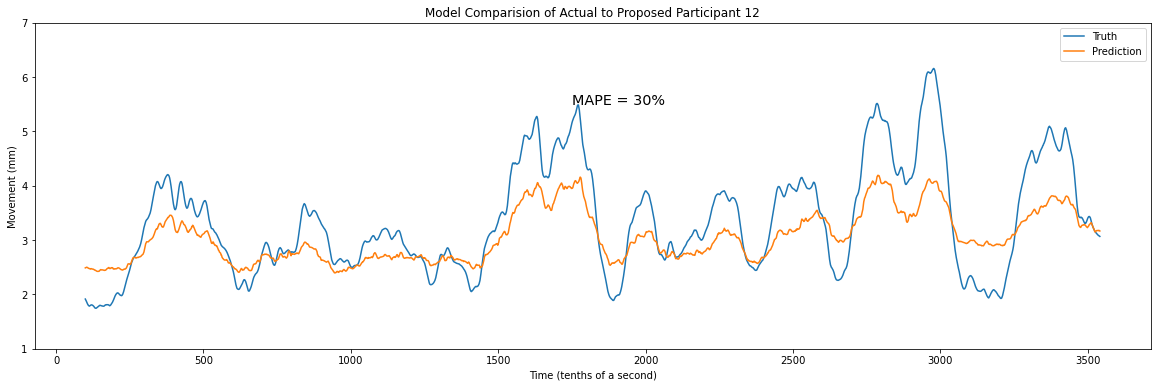

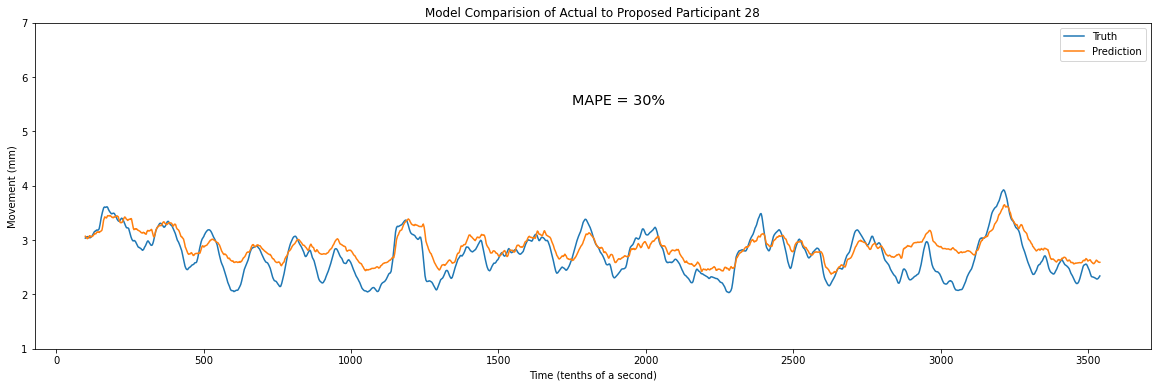

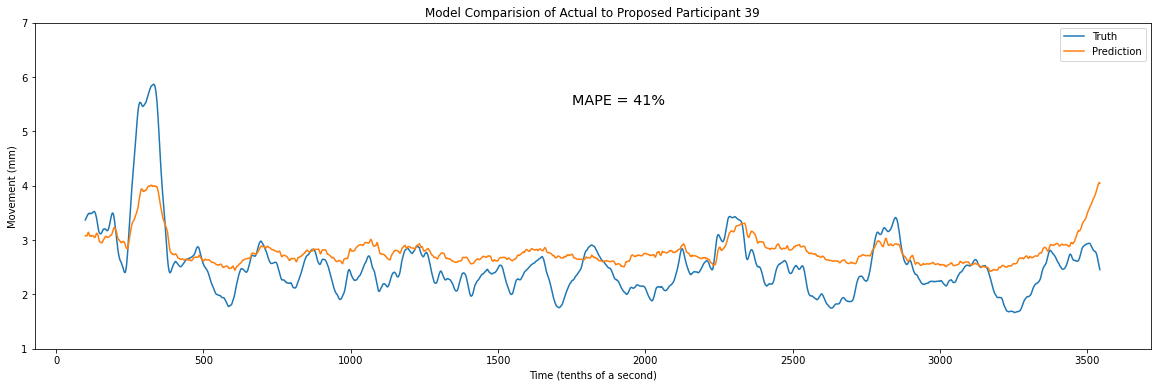

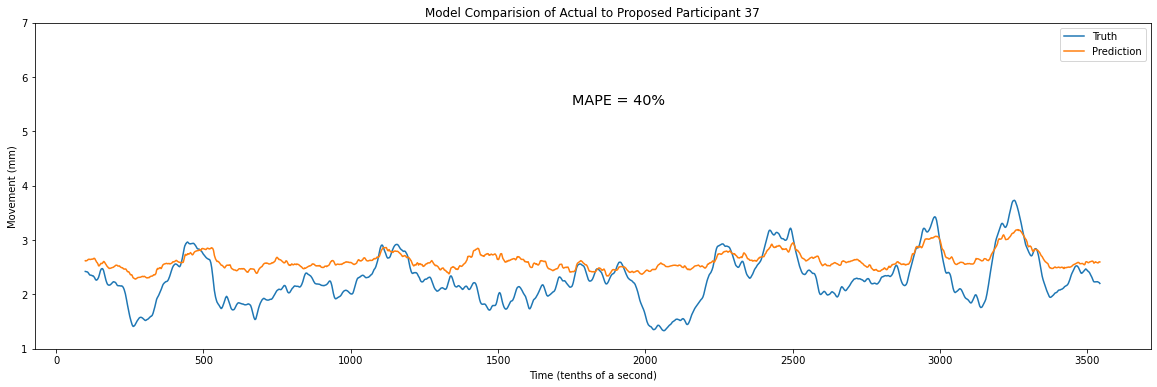

In [13]:
results, rf_scores = score_model(rf50, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='RF50', log = rf_scores)
plot_predictions(results, participants)

# RandomForest 250 Estimators

In [14]:
rf250 = RandomForestRegressor(n_estimators=250, verbose=True)
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
with joblib.parallel_backend('dask'):
    rf250.fit(train_X_pca50, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.9min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.3s finished


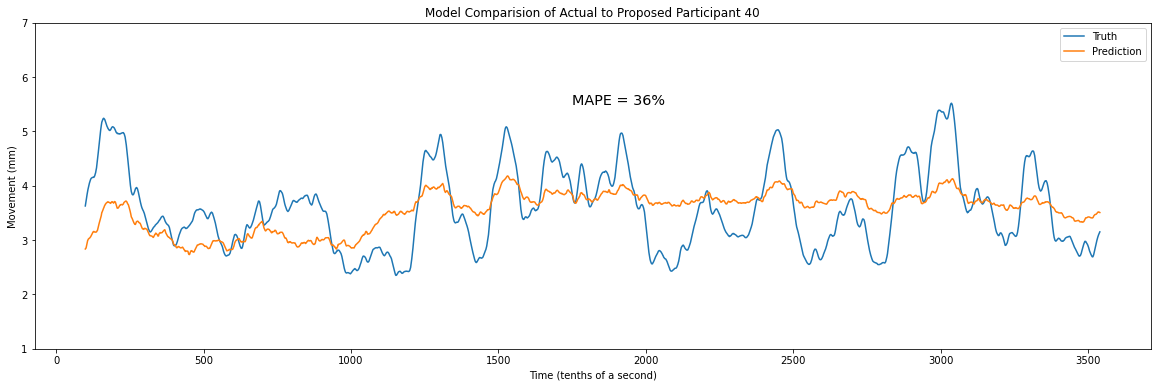

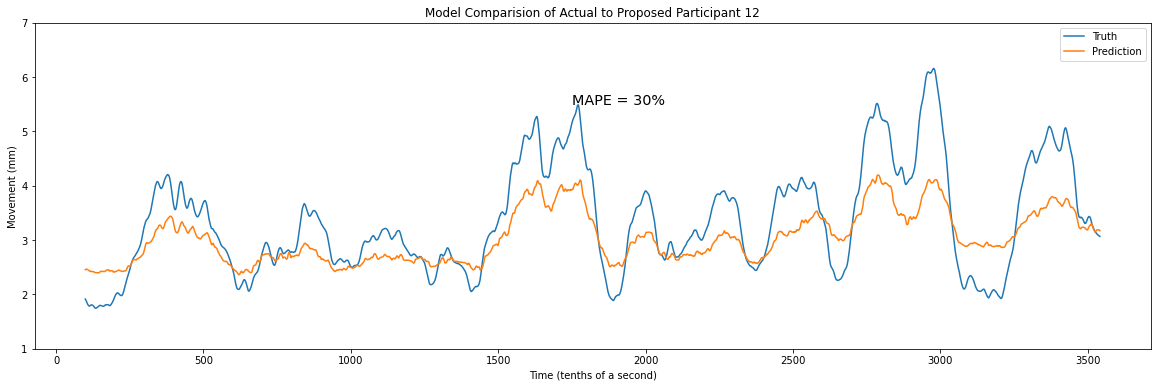

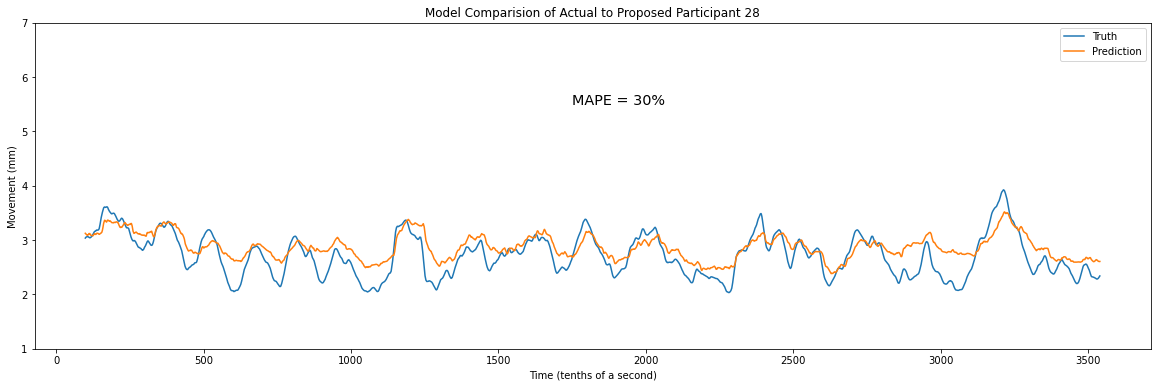

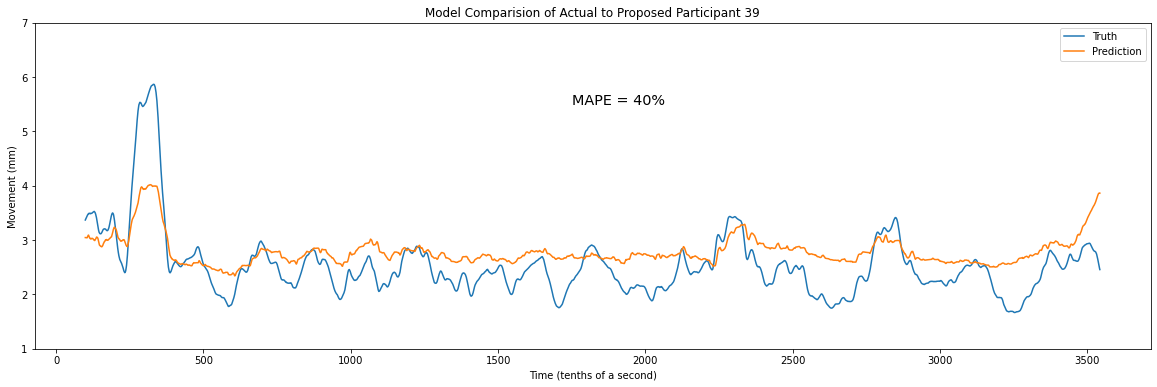

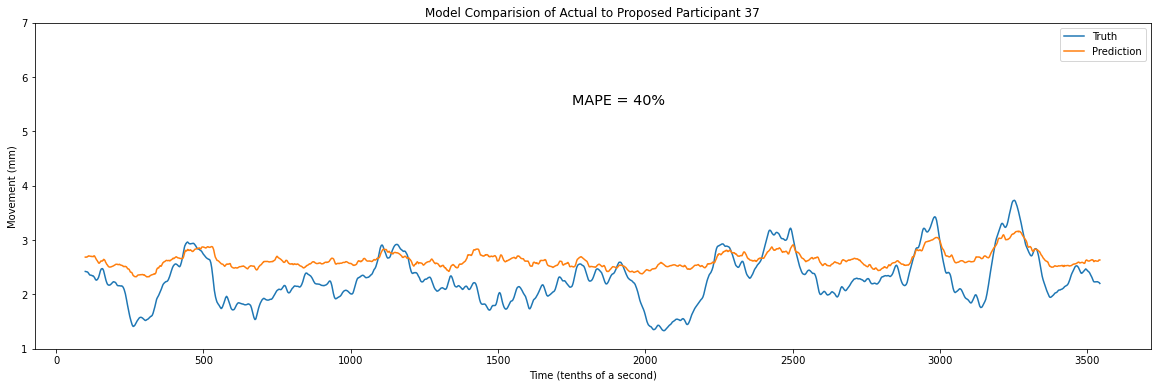

In [15]:
results, rf_scores = score_model(rf250, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                     model_name='RF250', log = rf_scores)
plot_predictions(results, participants)

In [16]:
rf_df = pd.DataFrame(rf_scores)

In [17]:
rf_df.groupby(['par','model']).mean()

MAPE       MAE  bootstrap  ccp_alpha  min_impurity_decrease  \
par model                                                                    
12  RF10   0.321239  0.972829       True        0.0                    0.0   
    RF250  0.301585  0.929059       True        0.0                    0.0   
    RF50   0.307538  0.941027       True        0.0                    0.0   
28  RF10   0.310641  0.725643       True        0.0                    0.0   
    RF250  0.301959  0.688262       True        0.0                    0.0   
    RF50   0.301897  0.693996       True        0.0                    0.0   
37  RF10   0.392045  0.723248       True        0.0                    0.0   
    RF250  0.406495  0.731952       True        0.0                    0.0   
    RF50   0.400151  0.724524       True        0.0                    0.0   
39  RF10   0.435091  0.858947       True        0.0                    0.0   
    RF250  0.405903  0.815496       True        0.0                    0.0   
    RF50   0.412096  0.829000       True        0.0                    0.0   
40  RF10   0.383498  1.154158       True        0.0                    0.0   
    RF250  0.362040  1.090605       True        0.0                    0.0   
    RF50   0.370854  1.111311       True        0.0                    0.0   

           min_samples_leaf  min_samples_split  min_weight_fraction_leaf  \
par model                                                                  
12  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
28  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
37  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
39  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   
40  RF10                  1                  2                       0.0   
    RF250                 1                  2                       0.0   
    RF50                  1                  2                       0.0   

           n_estimators  oob_score  verbose  warm_start  
par model                                                
12  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
28  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
37  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
39  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False  
40  RF10             10      False     True       False  
    RF250           250      False     True       False  
    RF50             50      False     True       False

In [18]:
rf_df.groupby(['model']).mean()

,par,MAPE,MAE,bootstrap,ccp_alpha,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,verbose,warm_start
model,,,,,,,,,,,,,
RF10,31.2,0.368503,0.886965,True,0.0,0.0,1.0,2.0,0.0,10.0,False,True,False
RF250,31.2,0.355596,0.851075,True,0.0,0.0,1.0,2.0,0.0,250.0,False,True,False
RF50,31.2,0.358507,0.859972,True,0.0,0.0,1.0,2.0,0.0,50.0,False,True,False


In [19]:
rf_df.to_pickle(r'DFs/scores/rf.pkl')